In [1]:
import torch

import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F



from PIL import Image
import matplotlib.pyplot as plt
from ChessModel import transfer_model


simlpenet = "./tmp/simplenet.pth"

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

transfer_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
train_losses = []
val_losses = []
test_losses = []
accuracies = []
test_accuracies = []


def train(model, optimizer, loss_fn, train_loader, val_loader, test_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        valid_loss = 0.0
        test_loss = 0.0
        accuracy = 0.0
        test_accuracy = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        train_losses.append(training_loss)
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        val_losses.append(valid_loss)
        accuracy = num_correct / num_examples
        accuracies.append(accuracy)

        num_correct = 0
        num_examples = 0
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            test_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        test_loss /= len(test_loader.dataset)
        test_losses.append(valid_loss)
        test_accuracy = num_correct / num_examples
        test_accuracies.append(test_accuracy)
        print(
            'Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f},Test Loss: {:.2f}, accuracy = {:.2f},test accuracy = {:.2f}'.format(
                epoch, training_loss,
                valid_loss, test_loss,
                accuracy, test_accuracy))

In [6]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from ChessModel import transfer_model

def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False



dirname = 'c:\chessImages'


train_data_path = dirname + '/train/'

img_transfors = transforms.Compose([
    transforms.Resize((100, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    #transforms.ColorJitter(0, 0, 0, 0),
    #transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomVerticalFlip(0.5),
    #transforms.RandomGrayscale(0.1),
    ])


train_data = ImageFolder(root=train_data_path,
                         transform=img_transfors,
                         is_valid_file=check_image)

val_data_path = dirname + '/valid/'
val_data = ImageFolder(root=val_data_path,
                         transform=img_transfors,
                         is_valid_file=check_image)

test_data_path = dirname + '/test/'
test_data = ImageFolder(root=test_data_path,
                         transform=img_transfors,
                         is_valid_file=check_image)
batch_size = 32
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(len(val_data_loader.dataset))

transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, test_data_loader, epochs=40,
      device=device)

torch.save(transfer_model.state_dict(), simlpenet)

236


C:\Users\PC83\AppData\Local\Temp/ipykernel_9232/1201528221.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
C:\Users\PC83\AppData\Local\Temp/ipykernel_9232/1201528221.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 1.04, Validation Loss: 0.58,Test Loss: 0.63, accuracy = 0.82,test accuracy = 0.79
Epoch: 2, Training Loss: 0.47, Validation Loss: 0.33,Test Loss: 0.35, accuracy = 0.89,test accuracy = 0.88
Epoch: 3, Training Loss: 0.22, Validation Loss: 0.25,Test Loss: 0.27, accuracy = 0.92,test accuracy = 0.91
Epoch: 4, Training Loss: 0.13, Validation Loss: 0.22,Test Loss: 0.25, accuracy = 0.92,test accuracy = 0.92
Epoch: 5, Training Loss: 0.09, Validation Loss: 0.32,Test Loss: 0.35, accuracy = 0.89,test accuracy = 0.89
Epoch: 6, Training Loss: 0.06, Validation Loss: 0.23,Test Loss: 0.26, accuracy = 0.92,test accuracy = 0.94
Epoch: 7, Training Loss: 0.06, Validation Loss: 0.25,Test Loss: 0.31, accuracy = 0.92,test accuracy = 0.91
Epoch: 8, Training Loss: 0.06, Validation Loss: 0.18,Test Loss: 0.26, accuracy = 0.93,test accuracy = 0.93
Epoch: 9, Training Loss: 0.04, Validation Loss: 0.31,Test Loss: 0.37, accuracy = 0.93,test accuracy = 0.93
Epoch: 10, Training Loss: 0.06, Valid

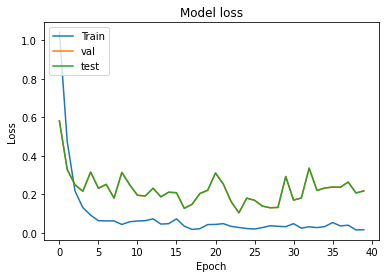

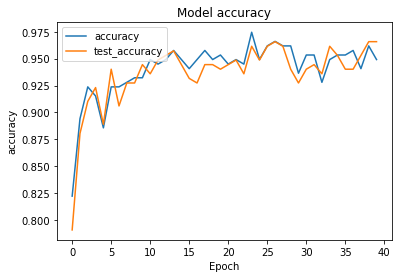

In [7]:
# Plot training & validation loss values
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(test_losses)

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val','test'], loc='upper left')
plt.show()

plt.plot(accuracies)
plt.plot(test_accuracies)
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'test_accuracy'], loc='upper left')
plt.show()